In [ ]:
# -----------------------------
# 1️⃣ Import thư viện cần thiết
# -----------------------------
import numpy as np
import pandas as pd

In [10]:
"""
Q-Learning for Inventory Management (based on the paper's case study)
---------------------------------------------------------------------
Tác giả: ChatGPT (GPT-5)

📘 Mục tiêu:
Mô phỏng quá trình quản lý tồn kho của một sản phẩm duy nhất bằng thuật toán Q-learning.
Thuật toán học cách ra quyết định "có nên đặt hàng hay không" dựa trên mức tồn kho hiện tại.

⚙️ Các giả định & thông số (theo bài báo):
- Nhu cầu (Demand) tuân theo phân phối chuẩn N(μ=3, σ=1)
- Thời gian giao hàng (Lead Time, LT) = 1 ngày
- Số lượng đặt hàng (Order quantity, q) = 6 đơn vị
- Điểm đặt hàng lại (Reorder point, r) = 3
- Chi phí đặt hàng (Ordering cost, O) = 50 €/đơn hàng
- Chi phí lưu kho (Holding cost, h) = 10 €/đơn vị-năm
- Chi phí thiếu hàng (Backorder cost, b) = 20 €/đơn vị-năm

Thuật toán RL này tìm chính sách đặt hàng tối ưu để giảm tổng chi phí.
"""

# -----------------------------
# 2️⃣ Cấu hình tham số của mô hình tồn kho
# -----------------------------
np.random.seed(0)  # giúp kết quả có thể tái lập được (reproducible)

# --- Thông số cầu (Demand) ---
mu = 3.0        # Nhu cầu trung bình mỗi ngày
sigma = 1.0     # Độ lệch chuẩn của nhu cầu
LT = 1          # Lead time = 1 ngày (đơn hàng đến vào ngày kế tiếp)

# --- Chi phí ---
O = 50.0        # Chi phí đặt hàng (€/đơn hàng)
h_annual = 10.0 # Chi phí lưu kho (€/đơn vị-năm)
b_annual = 20.0 # Chi phí thiếu hàng (€/đơn vị-năm)
days_per_year = 365.0
h = h_annual / days_per_year  # quy đổi chi phí lưu kho về đơn vị €/đơn vị-ngày
b = b_annual / days_per_year  # quy đổi chi phí thiếu hàng về €/đơn vị-ngày

# --- Chính sách (r,q) cơ bản ---
q_eoq = 6   # Số lượng đặt hàng EOQ
r_reorder = 3  # Điểm đặt hàng lại (reorder point)

# -----------------------------
# 3️⃣ Tham số Q-learning
# -----------------------------
alpha = 0.5             # Learning rate
gamma = 0.5             # Discount factor
epsilon_start = 0.3     # Xác suất khám phá ban đầu
epsilon_end = 0.01      # Xác suất khám phá tối thiểu
epsilon_decay_episodes = 800  # số episode để giảm epsilon dần
num_episodes = 1000     # tổng số episode huấn luyện
episode_length = 365     # mỗi episode = 1 năm (365 ngày)

# -----------------------------
# 4️⃣ Môi trường học (State và Action)
# -----------------------------
# Trạng thái: vị trí tồn kho (inventory position)
# Dải giá trị tồn kho [-20, 20] (âm = thiếu hàng)
min_IP, max_IP = -20, 20
states = np.arange(min_IP, max_IP + 1)

# Hành động: 0 = không đặt hàng, 1 = đặt hàng (số lượng q_eoq)
actions = [0, 1]

# Khởi tạo bảng Q-table (số trạng thái x số hành động)
Q = np.zeros((len(states), len(actions)))


def ip_to_index(ip):
    """Chuyển giá trị tồn kho sang chỉ số mảng Q-table (có cắt ngưỡng)."""
    return int(np.clip(round(ip), min_IP, max_IP)) - min_IP


def sample_demand():
    """Tạo nhu cầu ngẫu nhiên theo phân phối chuẩn N(μ, σ), không âm."""
    d = np.random.normal(mu, sigma)
    return max(0, int(round(d)))


def step(ip, orders_in_transit, action):
    """
    Mô phỏng một ngày hoạt động:
    1️⃣ Nếu có đơn hàng đang vận chuyển, nó đến hôm nay (LT=1)
    2️⃣ Nhu cầu xảy ra và trừ khỏi tồn kho
    3️⃣ Nếu hành động = 1, đặt đơn hàng mới (đến ngày mai)
    4️⃣ Tính chi phí lưu kho, thiếu hàng, đặt hàng trong ngày
    """
    # Nhập hàng đến
    arrivals = 0
    if orders_in_transit > 0:
        arrivals = orders_in_transit
        orders_in_transit = 0

    # Cập nhật tồn kho sau khi nhận hàng
    ip_after_arrival = ip + arrivals

    # Trừ đi nhu cầu
    d = sample_demand()
    ip_after_demand = ip_after_arrival - d

    # Nếu hành động = đặt hàng → đơn hàng sẽ đến vào ngày sau
    order_placed = False
    if action == 1:
        order_placed = True
        orders_in_transit = q_eoq

    # Tính chi phí
    holding_cost = h * max(ip_after_demand, 0)
    backorder_cost = b * max(-ip_after_demand, 0)
    ordering_cost = O if order_placed else 0
    total_cost = holding_cost + backorder_cost + ordering_cost

    # Phần thưởng = -chi phí (RL muốn tối đa hóa reward)
    reward = -total_cost
    next_ip = ip_after_demand

    return next_ip, reward, orders_in_transit, total_cost


# -----------------------------
# 5️⃣ Vòng lặp huấn luyện Q-learning
# -----------------------------
episode_costs = []

for ep in range(num_episodes):
    # Giảm dần epsilon (chính sách khám phá - khai thác)
    epsilon = max(
        epsilon_end,
        epsilon_start - (epsilon_start - epsilon_end) * (ep / epsilon_decay_episodes)
    )

    ip = r_reorder  # khởi tạo tồn kho = điểm đặt hàng lại
    orders_in_transit = 0
    total_cost_ep = 0

    for day in range(episode_length):
        s_idx = ip_to_index(ip)

        # Epsilon-greedy: chọn hành động ngẫu nhiên hoặc tối ưu theo Q
        if np.random.rand() < epsilon:
            a = np.random.choice(actions)
        else:
            qvals = Q[s_idx, :]
            a = np.random.choice(np.flatnonzero(qvals == qvals.max()))

        # Thực hiện hành động và nhận phản hồi từ môi trường
        next_ip, reward, orders_in_transit, cost = step(ip, orders_in_transit, a)

        # Cập nhật Q-table (theo công thức trong bài)
        s_next = ip_to_index(next_ip)
        Q[s_idx, a] += alpha * (reward + gamma * np.max(Q[s_next, :]) - Q[s_idx, a])

        # Cập nhật trạng thái
        ip = next_ip
        total_cost_ep += cost

    episode_costs.append(total_cost_ep)

print("✅ Huấn luyện hoàn tất.")

# -----------------------------
# 6️⃣ Trích xuất chính sách tối ưu từ Q-table
# -----------------------------
policy = np.argmax(Q, axis=1)  # chọn hành động tốt nhất ở mỗi trạng thái


# -----------------------------
# 7️⃣ Hàm mô phỏng đánh giá chính sách
# -----------------------------
def learned_policy(ip):
    """Chính sách do mô hình học được."""
    return int(policy[ip_to_index(ip)])


def rq_policy(ip):
    """Chính sách (r,q) truyền thống."""
    return 1 if ip <= r_reorder else 0


def evaluate(policy_func, days=365 * 5, seed=42):
    """Mô phỏng thực tế trong nhiều ngày để tính chi phí trung bình/ngày."""
    np.random.seed(seed)
    total_cost = 0
    ip = r_reorder
    orders_in_transit = 0
    for day in range(days):
        a = policy_func(ip)
        next_ip, _, orders_in_transit, cost = step(ip, orders_in_transit, a)
        ip = next_ip
        total_cost += cost
    return total_cost / days


# -----------------------------
# 8️⃣ Đánh giá hiệu quả của chính sách học được
# -----------------------------
learned_cost = evaluate(learned_policy)
rq_cost = evaluate(rq_policy)
reduction = (rq_cost - learned_cost) / rq_cost * 100

print(f"\n📊 Kết quả so sánh:")
print(f" - Chính sách học được: {learned_cost:.2f} €/ngày")
print(f" - Chính sách (r,q) truyền thống: {rq_cost:.2f} €/ngày")
print(f" - Tỷ lệ cải thiện: {reduction:.2f}%")

# -----------------------------
# 9️⃣ Hiển thị chính sách học được
# -----------------------------
policy_df = pd.DataFrame({
    "inventory_position": states,
    "action (0=no order,1=order)": policy
})

print("\n🔎 Một phần của chính sách học được:")
print(policy_df)



✅ Huấn luyện hoàn tất.

📊 Kết quả so sánh:
 - Chính sách học được: 151.24 €/ngày
 - Chính sách (r,q) truyền thống: 25.49 €/ngày
 - Tỷ lệ cải thiện: -493.43%

🔎 Một phần của chính sách học được:
    inventory_position  action (0=no order,1=order)
0                  -20                            0
1                  -19                            0
2                  -18                            0
3                  -17                            0
4                  -16                            0
5                  -15                            0
6                  -14                            0
7                  -13                            0
8                  -12                            0
9                  -11                            0
10                 -10                            0
11                  -9                            0
12                  -8                            0
13                  -7                            0
14                  -6    

In [12]:
# ===============================================================
# 🔟 Mô phỏng 1 năm để quan sát Nhu cầu, Tồn kho và Hành động
# ===============================================================
np.random.seed(123)
days = np.arange(1, 31)  # mô phỏng 30 ngày đầu để dễ quan sát
ip = r_reorder
orders_in_transit = 0
records = []

for day in days:
    a = learned_policy(ip)                # hành động theo chính sách học được
    d = sample_demand()                   # nhu cầu ngẫu nhiên của ngày
    arrivals = 0
    if orders_in_transit > 0:
        arrivals = orders_in_transit
        orders_in_transit = 0
    ip_after = ip + arrivals - d          # cập nhật tồn kho sau nhu cầu
    if a == 1:
        orders_in_transit = q_eoq         # nếu đặt hàng, hàng đến ngày sau
    records.append({
        "day": day,
        "demand": d,
        "inventory_before": ip,
        "order_action": a,
        "arrivals_today": arrivals,
        "inventory_after": ip_after
    })
    ip = ip_after

df_sim = pd.DataFrame(records)
print("\n📅 Dữ liệu mô phỏng 30 ngày đầu:")
print(df_sim.to_string(index=False))



📅 Dữ liệu mô phỏng 30 ngày đầu:
 day  demand  inventory_before  order_action  arrivals_today  inventory_after
   1       2                 3             0               0                1
   2       4                 1             0               0               -3
   3       3                -3             0               0               -6
   4       1                -6             0               0               -7
   5       2                -7             0               0               -9
   6       5                -9             0               0              -14
   7       1               -14             0               0              -15
   8       3               -15             0               0              -18
   9       4               -18             0               0              -22
  10       2               -22             0               0              -24
  11       2               -24             0               0              -26
  12       3               -26 

In [13]:
# ===============================================================
# 🔟 Vẽ biểu đồ tương tự Figure 3 và Figure 4 trong bài báo
# ===============================================================
import matplotlib.pyplot as plt

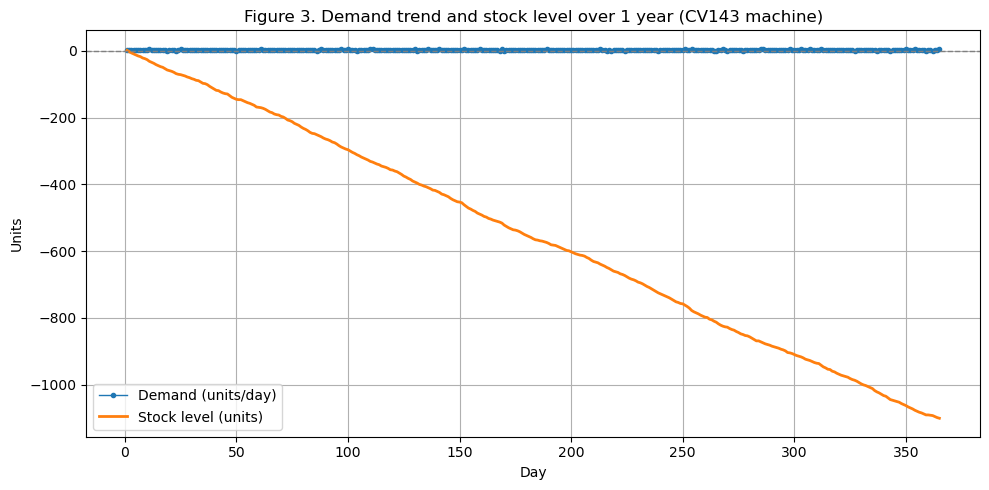

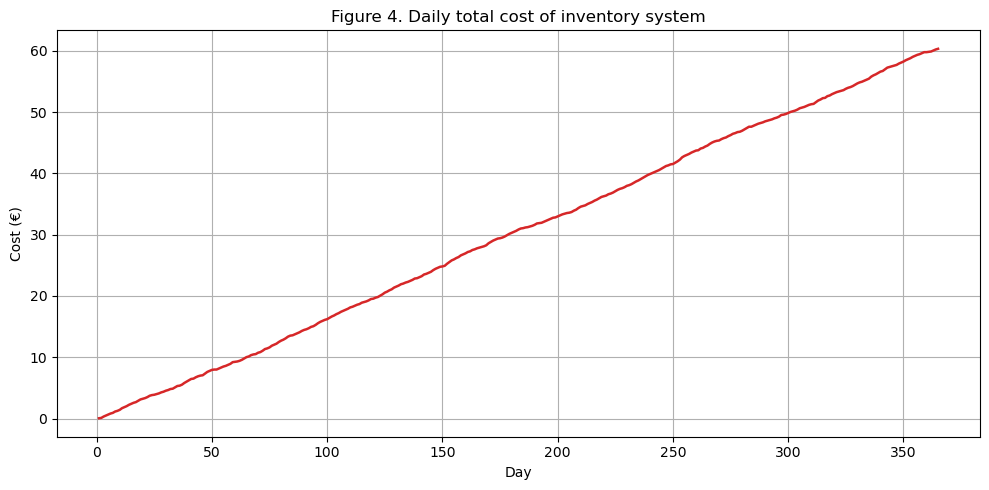

📊 Figure 3 và Figure 4 đã được tạo thành công!


In [14]:
# -------------------------------
# 1️⃣ Mô phỏng 1 năm để ghi lại dữ liệu demand, stock, cost
# -------------------------------
np.random.seed(100)
days = np.arange(1, 366)
ip = r_reorder
orders_in_transit = 0
history = []

for day in days:
    a = learned_policy(ip)  # hành động theo chính sách học được
    next_ip, _, orders_in_transit, total_cost = step(ip, orders_in_transit, a)

    # Ghi lại dữ liệu để vẽ biểu đồ
    history.append({
        "day": day,
        "demand": np.random.normal(mu, sigma),  # cầu trong ngày (minh họa)
        "stock_level": next_ip,                 # tồn kho sau khi trừ cầu
        "total_cost": total_cost,               # chi phí tổng của ngày
        "order_action": a                       # hành động (0/1)
    })
    ip = next_ip

df = pd.DataFrame(history)

# -------------------------------
# 2️⃣ Biểu đồ Figure 3: Demand trend & Stock level
# -------------------------------
plt.figure(figsize=(10, 5))
plt.plot(df["day"], df["demand"], label="Demand (units/day)", color="tab:blue",
         marker="o", markersize=3, linewidth=1)
plt.plot(df["day"], df["stock_level"], label="Stock level (units)", color="tab:orange",
         linewidth=2)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Figure 3. Demand trend and stock level over 1 year (CV143 machine)")
plt.xlabel("Day")
plt.ylabel("Units")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# 3️⃣ Biểu đồ Figure 4: Daily total cost
# -------------------------------
plt.figure(figsize=(10, 5))
plt.plot(df["day"], df["total_cost"], color="tab:red", linewidth=1.8)
plt.title("Figure 4. Daily total cost of inventory system")
plt.xlabel("Day")
plt.ylabel("Cost (€)")
plt.grid(True)
plt.tight_layout()
plt.show()

print("📊 Figure 3 và Figure 4 đã được tạo thành công!")